# Predicting Income Brackets With SciKit-Learn

This noteboook is going to go through a couple different methods for ML classification with SciKit-Learn and trying to optimize the predictions we can create while keeping it relatively simple.

The data was originally collected in 1994 and can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_income = pd.read_csv(r'C:\Users\Owner\Downloads\adult.csv')

## Exploratory Analysis

First, we want to get a feel for what our data is and what we will be predicting.

This data contains information about adults with defining features such as: age, education, race, native country, etc. But most importantly for us today, it contains whether the person makes above or below $50,000 per year, which is what we will be trying to predict.

In [2]:
print(df_income.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50


Next, we should check out the distribution of greater than and less than 50k. As we can see from the bar chart below, there is about 3X as many instances of <=50k than >50k. While definitley not the most balanced data, it's not terrible so let's see what else we can find out about the data, and maybe we will come back to addressing this balance problem if we are unsatisfied with the prediction power of our models.


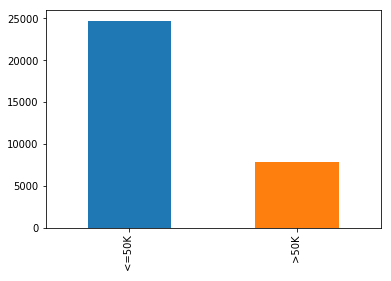

In [3]:
income_count_bar = df_income['income'].value_counts().plot(kind = 'bar')

Now I want to take a look at our continuous and ordinal variables and see if there are any patterns amongst them or in relation to our income brackets.

Below, instances of <=50k are in blue and >50k are in orange, and the first thing I notice is that as a person is more educated, they are more likely to make >50k, which makes a lot of sense. With regards to age, it appears very rare to make more than 50k until the age of about 26, but afterwards the rate does not appear to change too much. A similar phenomenon can also be found in the hours-per-week category as we would expect people working part time to not make as much money. The main relation that I can identify between two factors is another intuitve one, that as people get older past 60, they are less likely to work a lot of hours.

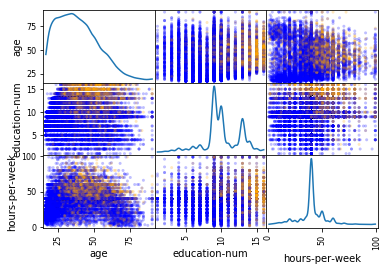

In [4]:
bracket_color_list = []
for x in df_income.loc[:, 'income']:
    if x == ' <=50K':
        bracket_color_list.append('blue')
    else:
        bracket_color_list.append('orange')
pd.plotting.scatter_matrix(df_income.loc[:, ['age', 'education-num', 'hours-per-week']], c = bracket_color_list, alpha = .25, diagonal = 'kde')
plt.show()

## K Nearest Neighbors

The first classification algorithm I want to try out is K Nearest Neighbors classification.

This algorithm works by plotting out all the training data and then seeing how close a test value is to those points, since we are plotting data, we can't really use our nominal categorical data, so the columns we will use to train our model are: age, education level, hours worked per week, capital gain, and capital loss. 

Ultimatley we are going to want to judge our model based off its ability to predict if someone makes >50k since that will be tougher but I want to record overall accuracy and predicting <=50k so that we can compare all 3 evaluation methods.

In KNN the only hyperparamter we want to try and optimize is "k" itself. This will determine how many close training points can 'vote' on whether a testing point belongs to its category (<=/>50k). So, we will iterate k from 1 to 100, train and test the model on each k, and plot which k does the best.

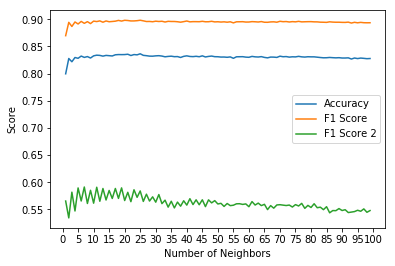

Top accuracy: 0.8364213327873887 
Top K: 25
Top F1 Score (Positive: <50K): 0.8982035928143712 
Top K: 25
Top F1 Score 2 (Positive: >50K): 0.5910990902385049 
Top K: 7


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
x = df_income.loc[:, ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']]
y = df_income.loc[:, 'income']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .3, random_state = 40)
hyperparam = np.arange(1, 100)
accuracy = []
f1_list = []
f1_list2 = []

for x, k in enumerate(hyperparam):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    accuracy.append(knn.score(x_test, y_test))
    y_pred = knn.predict(x_test)
    f1_list.append(f1_score(y_test, y_pred, pos_label = ' <=50K'))
    f1_list2.append(f1_score(y_test, y_pred, pos_label = ' >50K'))
plt.plot(hyperparam, accuracy, label = 'Accuracy')
plt.plot(hyperparam, f1_list, label = 'F1 Score')
plt.plot(hyperparam, f1_list2, label = 'F1 Score 2')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.xticks(np.arange(min(hyperparam) - 1, max(hyperparam) + 2, 5))
plt.legend()
plt.show()
print('Top accuracy:', np.max(accuracy), '\nTop K:', 1 + accuracy.index(np.max(accuracy)))
print('Top F1 Score (Positive: <50K):', np.max(f1_list), '\nTop K:', 1 + f1_list.index(np.max(f1_list)))
print('Top F1 Score 2 (Positive: >50K):', np.max(f1_list2), '\nTop K:', 1 + f1_list2.index(np.max(f1_list2)))

Accuracy is a simple metic that just divides correct predictions by total predictions. The problem with this in the context of our problem, is that ~75%  of our data is from <=50k, so any good predictions involving them will outweigh and mask the worse predictions invloving >50k, which is why we ultimatley want to judge based on >50k's F1 score, balancing both precision and recall.

We can generate a confusion matrix which will help visualize our concerns. As we can see below, the problem really arrises when the testing variable is actually >50k, but our model only predicts that 51% of the time. To address this we could try some undersampling or oversampling our training data, but for now lets try out some more algorithms. 

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
df_crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)
print('Confusion  Matrix\n')
print(df_crosstab)
class_report = classification_report(y_test, y_pred)
print('\nClassification Report\n')
print(class_report)

Confusion  Matrix

Predicted   <=50K   >50K   All
Actual                        
 <=50K       6904    493  7397
 >50K        1170   1202  2372
All          8074   1695  9769

Classification Report

             precision    recall  f1-score   support

      <=50K       0.86      0.93      0.89      7397
       >50K       0.71      0.51      0.59      2372

avg / total       0.82      0.83      0.82      9769



## Decision Tree

The next algorithm I want to try is the Decision Tree, which will enable us to use our nominal categorical variables to help predict our income bracket.

Unfortunatley, SciKit does not allow for string based categorical variables so we need to convert them to integers. We can't just convert them to random numbers within the column because then SciKit would associate some sort of order where we don't intend one. Instead we need to do One Hot encoding which will create a column for every categorical value, and then each value will be a 1 or 0, representing True and False. So, using pd.get_dummies we create these new columns and then drop the two columns we don't need from our updated dataframe (Education: which is just a the string associated with education-num, and fnlwgt: which is supposed to show the aprroximate # of people the given adult represents in America)

In [7]:
cat_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
df_income_update = pd.get_dummies(df_income, prefix_sep='_', columns = cat_columns)
df_income_update = df_income_update.drop(['fnlwgt', 'education'], axis = 1)

Now we need to re-split our data based on our new dataframe and then train and test our decision tree. 

We can see from our classification report that while our >50k precision decreased by .08, our recall increasd by .10, and our f1 score increased by a modest .03.

In [8]:
from sklearn.tree import DecisionTreeClassifier
x = df_income_update.loc[:, df_income_update.columns != 'income']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .3, random_state = 40)
dtc = DecisionTreeClassifier().fit(x_train, y_train)
y_pred = dtc.predict(x_test)
df_crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)
print('Confusion  Matrix\n')
print(df_crosstab)
class_report = classification_report(y_test, y_pred)
print('\n\nClassification Report\n')
print('\n', class_report)

Confusion  Matrix

Predicted   <=50K   >50K   All
Actual                        
 <=50K       6555    842  7397
 >50K         921   1451  2372
All          7476   2293  9769


Classification Report


              precision    recall  f1-score   support

      <=50K       0.88      0.89      0.88      7397
       >50K       0.63      0.61      0.62      2372

avg / total       0.82      0.82      0.82      9769



What we can do now is analyze how important each of our features are, and decide which ones we need to keep.

dtc.feature_importances_ will give us a percentage of how much of our prediction comes from a single feature. We can see below that features such as age and education, as I predicted in the begining, go a long way towards predicting what income bracket someone falls into. I decided to set a lower bound of .1% (.001) and to remove any features that don't contribute at least that much. That brings our number of features from 91 to 48.

In [9]:
column_list = []
for x in df_income_update.columns:
    if 'income' not in x:
        column_list.append(x)
feature_dict = dict(zip(column_list, dtc.feature_importances_))
new_columns = []
for x in feature_dict:
    if feature_dict[x] > .001:
        new_columns.append(x)
        print(x,':', format(feature_dict[x], '.3f'))
print(len(new_columns))
print(len(column_list))

age : 0.164
education-num : 0.150
capital-gain : 0.116
capital-loss : 0.042
hours-per-week : 0.099
workclass_ ? : 0.002
workclass_ Federal-gov : 0.007
workclass_ Local-gov : 0.008
workclass_ Private : 0.015
workclass_ Self-emp-inc : 0.007
workclass_ Self-emp-not-inc : 0.011
workclass_ State-gov : 0.006
marital-status_ Divorced : 0.004
marital-status_ Married-civ-spouse : 0.213
marital-status_ Never-married : 0.004
marital-status_ Separated : 0.001
marital-status_ Widowed : 0.001
occupation_ ? : 0.002
occupation_ Adm-clerical : 0.007
occupation_ Craft-repair : 0.009
occupation_ Exec-managerial : 0.010
occupation_ Farming-fishing : 0.005
occupation_ Handlers-cleaners : 0.003
occupation_ Machine-op-inspct : 0.005
occupation_ Other-service : 0.005
occupation_ Prof-specialty : 0.009
occupation_ Protective-serv : 0.003
occupation_ Sales : 0.009
occupation_ Tech-support : 0.005
occupation_ Transport-moving : 0.007
relationship_ Husband : 0.003
relationship_ Not-in-family : 0.004
relationship_

As we can see below, removing almost half of our features from this specific decsision tree makes only negligible changes to our precision and recall, while making the model much simpler and more efficent, but there is still plenty of room for improvent in our predictions.

In [10]:
x = df_income_update.loc[:, new_columns]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .3, random_state = 40)
dtc = DecisionTreeClassifier().fit(x_train, y_train)
y_pred = dtc.predict(x_test)
df_crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)
print('Confusion  Matrix\n')
print(df_crosstab)
class_report = classification_report(y_test, y_pred)
print('\n\nClassification Report\n')
print('\n', class_report)

Confusion  Matrix

Predicted   <=50K   >50K   All
Actual                        
 <=50K       6559    838  7397
 >50K         926   1446  2372
All          7485   2284  9769


Classification Report


              precision    recall  f1-score   support

      <=50K       0.88      0.89      0.88      7397
       >50K       0.63      0.61      0.62      2372

avg / total       0.82      0.82      0.82      9769



## Random Forest

The final algorithm I want to try out is the Random Forest, which randomly generates multiple decision trees to find an optimal combination of features and certain hyperparameters.

To begin, I will restore all of our features and try out a random forest with the default hyperparameters. The result of this gives a good sized benefit to our precision, and a slight detriment to our recall, so lets see if we can modify it to further optimize our predictions.

In [11]:
from sklearn.ensemble import RandomForestClassifier
x = df_income_update.loc[:, df_income_update.columns != 'income']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state = 40)
rfc = RandomForestClassifier().fit(x_train, y_train)
y_pred = rfc.predict(x_test)
df_crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)
print('Confusion  Matrix\n')
print(df_crosstab)
class_report = classification_report(y_test, y_pred)
print('\n\nClassification Report\n')
print('\n', class_report)

Confusion  Matrix

Predicted   <=50K   >50K   All
Actual                        
 <=50K       6801    596  7397
 >50K         969   1403  2372
All          7770   1999  9769


Classification Report


              precision    recall  f1-score   support

      <=50K       0.88      0.92      0.90      7397
       >50K       0.70      0.59      0.64      2372

avg / total       0.83      0.84      0.83      9769



The first step we'll take is to apply the same lower bound to the feature importances so we can make our model simpler before iterating through different combinations of hyperparameters. This brings us down to 50 features.

In [12]:
column_list = []
for x in df_income_update.columns:
    if 'income' not in x:
        column_list.append(x)
feature_dict = dict(zip(column_list, rfc.feature_importances_))
new_columns = []
for x in feature_dict:
    if feature_dict[x] > .001:
        new_columns.append(x)
        print(x,':', format(feature_dict[x], '.3f'))
print(len(new_columns))
print(len(column_list))

age : 0.218
education-num : 0.138
capital-gain : 0.111
capital-loss : 0.036
hours-per-week : 0.115
workclass_ ? : 0.002
workclass_ Federal-gov : 0.005
workclass_ Local-gov : 0.006
workclass_ Private : 0.010
workclass_ Self-emp-inc : 0.006
workclass_ Self-emp-not-inc : 0.008
workclass_ State-gov : 0.006
marital-status_ Divorced : 0.006
marital-status_ Married-civ-spouse : 0.038
marital-status_ Never-married : 0.040
marital-status_ Separated : 0.002
marital-status_ Widowed : 0.003
occupation_ ? : 0.002
occupation_ Adm-clerical : 0.006
occupation_ Craft-repair : 0.007
occupation_ Exec-managerial : 0.019
occupation_ Farming-fishing : 0.004
occupation_ Handlers-cleaners : 0.004
occupation_ Machine-op-inspct : 0.004
occupation_ Other-service : 0.007
occupation_ Prof-specialty : 0.015
occupation_ Protective-serv : 0.003
occupation_ Sales : 0.007
occupation_ Tech-support : 0.005
occupation_ Transport-moving : 0.004
relationship_ Husband : 0.066
relationship_ Not-in-family : 0.011
relationship_

Removing the unnecessary features from our random forest improves our model slightly.

In [13]:
x = df_income_update.loc[:, new_columns]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .3, random_state = 40)
rfc = RandomForestClassifier().fit(x_train, y_train)
y_pred = rfc.predict(x_test)
df_crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)
print('Confusion  Matrix\n')
print(df_crosstab)
class_report = classification_report(y_test, y_pred)
print('\n\nClassification Report\n')
print('\n', class_report)

Confusion  Matrix

Predicted   <=50K   >50K   All
Actual                        
 <=50K       6814    583  7397
 >50K         952   1420  2372
All          7766   2003  9769


Classification Report


              precision    recall  f1-score   support

      <=50K       0.88      0.92      0.90      7397
       >50K       0.71      0.60      0.65      2372

avg / total       0.84      0.84      0.84      9769



Now we can utilize GridSearchCV which will try out every combination of our chosen hyperparameters and cross validate each 3 times. That's over 700 tasks to complete which is why its so crucial to remove any unnecessary features before iterating. This will enable us to figure out which hyperparameters maximize our model's predictive power.

In [14]:
from sklearn.model_selection import GridSearchCV
n_estimators_list = [100, 500, 1000, 2000]
max_depth_list = [5, 10, 25, 50]
min_samples_split_list = [2, 5, 15, 50]
min_samples_leaf_list = [1, 2, 5, 10]

hyper_dict = dict(n_estimators = n_estimators_list,
                 max_depth = max_depth_list,
                 min_samples_split = min_samples_split_list,
                 min_samples_leaf = min_samples_leaf_list)

grid_search = GridSearchCV(rfc, hyper_dict, cv = 3, verbose = 1, n_jobs = -1).fit(x_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 33.2min finished


This optimized random forest has now taken our f1 score from .59 to .68 and we can check which values from our hyperparameters produced this result and if we want, we can repeat GridSearchCV with values closer to these to further nail down the best hyperparameters.

In [15]:
y_pred = grid_search.predict(x_test)
df_crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)
print('Confusion  Matrix\n')
print(df_crosstab)
class_report = classification_report(y_test, y_pred)
print('\n\nClassification Report\n')
print('\n', class_report)

Confusion  Matrix

Predicted   <=50K   >50K   All
Actual                        
 <=50K       6980    417  7397
 >50K         932   1440  2372
All          7912   1857  9769


Classification Report


              precision    recall  f1-score   support

      <=50K       0.88      0.94      0.91      7397
       >50K       0.78      0.61      0.68      2372

avg / total       0.86      0.86      0.86      9769



In [16]:
print(grid_search.best_params_)

{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 100}


## Conclusion

Looking back on everything we did:
    - We did some preliminary analysis on a diverse data set
    - We trained a KNN model that got us an F1 score of .59 after tuning the hyperparamter "k"
    - We moved into decision trees and were able to determine what features were important
    - We applied both hyperparamter tuning and feature selection to a random forest and ultimately 
      imporved our F1 score by .09 or about 10%

What's next:
    - I will probably adjust the hyperparameters further on the random forest, especially the n_estimators considering
      that the optimal value was on the edge of the range I gave, so there's a decent chance the "true" optimal value is 
      outside of that range
    - The most important next step I feel is to adjust my training set to either undersample <=50k or oversample
      >50k. I believe this will balance out the prediction power between the two income brackets and raise our 
      F1 score for >50k even higher